In [1]:
#from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

df = pd.read_csv('data/raotb16.csv')
df

,date,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
0,1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1,1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
2,1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
3,1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
4,1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...,...
118,1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
119,1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
120,1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
121,1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6


In [2]:
df['Date'] = pd.to_datetime(df['date'], format = '%Y-%m')
df = df.set_index('Date')

In [3]:
df = df.drop(['date'], axis = 1)
df

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
Date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


In [4]:
maxlag = 12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    df2 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_index = np.argmin(p_values)
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
            df2.loc[r, c] = min_index
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df, df2

df_granger, df2 = grangers_causation_matrix(df, variables = df.columns) 
df_granger

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


In [5]:
df2 #Number of lags/comparison

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
rgnp,0.0,10.0,3.0,9.0,11.0,11.0,7.0,8.0
pgnp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ulc,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
gdfco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
gdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
gdfim,0.0,0.0,1.0,1.0,8.0,0.0,11.0,0.0
gdfcf,0.0,0.0,0.0,0.0,0.0,10.0,0.0,6.0
gdfce,4.0,0.0,3.0,1.0,1.0,0.0,9.0,0.0


test_result = grangercausalitytests(df[['rgnp', 'pgnp']], maxlag=12, verbose = False)
p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
p_values

In [6]:
#Stationarity?

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)
    if p_value <= signif:
        print(f"P={p_value}. Stationary.")
    else:
        print(f"P={p_value}. Non-Stationary.")
        
# ADF Test on each column

for name, column in df.iteritems():
    print(column.name, end=" || ")
    adfuller_test(column, name=column.name)

rgnp || P=0.9886. Non-Stationary.
pgnp || P=0.9965. Non-Stationary.
ulc || P=0.9971. Non-Stationary.
gdfco || P=0.987. Non-Stationary.
gdf || P=0.9953. Non-Stationary.
gdfim || P=0.9387. Non-Stationary.
gdfcf || P=0.9981. Non-Stationary.
gdfce || P=0.8144. Non-Stationary.


In [7]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)
    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


In [38]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


In [39]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

P=0.9861. Non-Stationary.


P=0.9957. Non-Stationary.


P=0.9963. Non-Stationary.


P=0.996. Non-Stationary.


P=0.9981. Non-Stationary.


P=0.9514. Non-Stationary.


P=0.9973. Non-Stationary.


P=0.9196. Non-Stationary.




In [40]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [41]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

P=0.0. Stationary.


P=0.3666. Non-Stationary.


P=0.0089. Stationary.


P=0.5637. Non-Stationary.


P=0.7034. Non-Stationary.


P=0.0009. Stationary.


P=0.2632. Non-Stationary.


P=0.0228. Stationary.




In [42]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [43]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

P=0.0. Stationary.


P=0.0. Stationary.


P=0.0. Stationary.


P=0.0. Stationary.


P=0.0. Stationary.


P=0.0. Stationary.


P=0.0. Stationary.


P=0.0. Stationary.




In [44]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.3679402315450646
BIC :  0.34118471465888556
FPE :  0.25526825173472023
HQIC:  -0.6741331335699536 

Lag Order = 2
AIC :  -1.6212373944478267
BIC :  1.6249432095295822
FPE :  0.20113494371371338
HQIC:  -0.303628882679595 

Lag Order = 3
AIC :  -1.765800838701281
BIC :  3.0345473163767815
FPE :  0.18125103746164334
HQIC:  0.1823914378396312 

Lag Order = 4
AIC :  -2.000735164470317
BIC :  4.371215137654088
FPE :  0.1555696652148111
HQIC:  0.5849359332771078 

Lag Order = 5
AIC :  -1.9619535608363972
BIC :  5.999364562242094
FPE :  0.18692794389114853
HQIC:  1.2682063311783311 

Lag Order = 6
AIC :  -2.330338652482907
BIC :  7.238452689088579
FPE :  0.16380374017443636
HQIC:  1.5514371669548055 

Lag Order = 7
AIC :  -2.592331352347127
BIC :  8.602387254937797
FPE :  0.18238685837154173
HQIC:  1.948306962114657 

Lag Order = 8
AIC :  -3.317261976458207
BIC :  9.522195810323028
FPE :  0.1557316324820906
HQIC:  1.8896071386220967 

Lag Order = 9
AIC :  -4.80476312595

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In [46]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


In [47]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Apr, 2021
Time:                     18:52:43
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

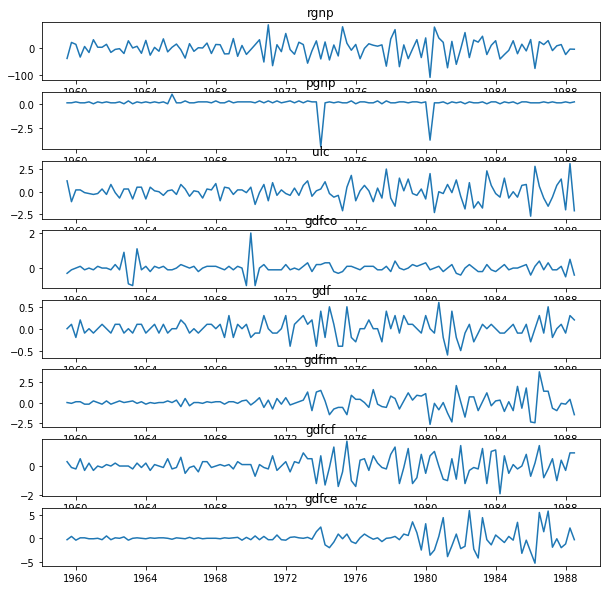

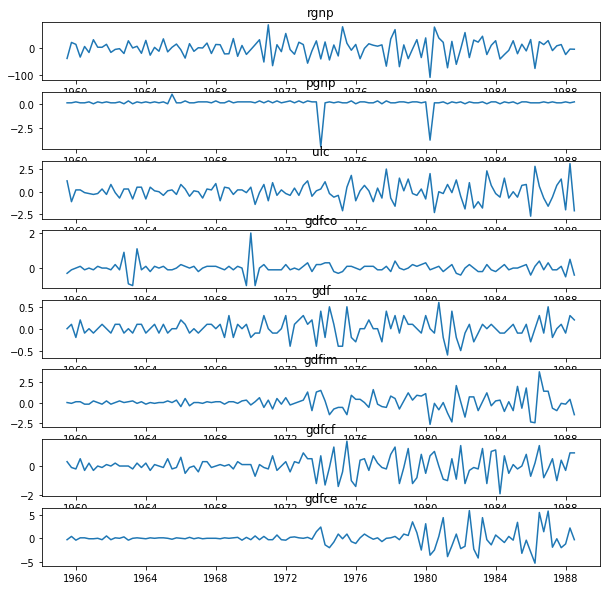

In [48]:
model_fitted.plot()